In [1]:
import os
import re
import heapq
import sklearn
import warnings
import numpy as np
import pandas as pd
from heapq import heappop
from heapq import heappush
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from IPython.display import display
from sklearn.metrics.pairwise import cosine_distances
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# HIDE WARNINGS
warnings.filterwarnings("ignore")

#### Create data set

Scan all news directories and read all '.txt' files.

In [2]:
path = "./news_data"
ids = list()
titles = list()
contents = list()
categories = list()
# FOR ALL DIRECTORIES
for directory in os.listdir(path):
    if os.path.isdir(f"{path}/{directory}/"):
        # FOR FILES IN EACH DIRECTORY
        for file in os.listdir(f"{path}/{directory}/"):
            if file.endswith(".txt"):
                ids.append(len(ids)+1)
                f = open(f"{path}/{directory}/{file}")
                lines = f.readlines()
                titles.append(lines[0])
                content = ""
                for line in lines[1:]:
                    content = content + " " + line
                contents.append(content)
                categories.append(directory)
# CREATE DATAFRAME
data_set = pd.DataFrame(columns=["id","title","content","category"])
data_set["id"] = ids
data_set["title"] = titles
data_set["content"] = contents
data_set["category"] = categories
# ASSOCIATE CATEGORY NAMES WITH NUMERICAL INDEX
data_set["category_id"] = data_set["category"].factorize()[0]
display(data_set.head(5))
# CREATE data_set.csv
data_set.to_csv("./data_sets/data_set.csv",sep="\t",index=False)

,id,title,content,category,category_id
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0
3,4,High fuel prices hit BA's profits\n,\n British Airways has blamed high fuel price...,business,0
4,5,Pernod takeover talk lifts Domecq\n,\n Shares in UK drinks and food firm Allied D...,business,0


#### Display five random samples

In [3]:
data_set.sample(5, random_state=0)

,id,title,content,category,category_id
384,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...,business,0
1983,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...,tech,4
985,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...,politics,2
1386,1387,Pavey focuses on indoor success\n,\n Jo Pavey will miss January's View From Gre...,sport,3
1294,1295,Tories reject rethink on axed MP\n,\n Sacked MP Howard Flight's local Conservati...,politics,2


#### Distribution of each category

category
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: category_id, dtype: int64

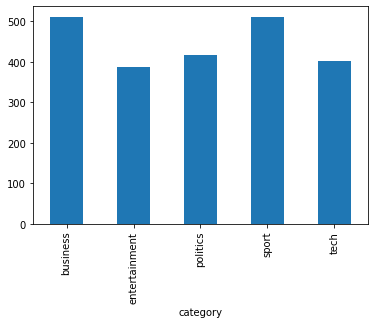

In [4]:
display(data_set.groupby("category").category_id.count())
display(data_set.groupby("category").category_id.count().plot.bar())

#### Create train set and test set

Split data set and create train and test set.

In [5]:
X = data_set.iloc[:,:-1].values
y = data_set.iloc[:,-1].values

# SPLIT DATA SET
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# CREATE TRAIN DATAFRAME
train_set = pd.DataFrame(X_train,columns=["id","title","content","category"])
train_set["category_id"] = pd.DataFrame(y_train,columns=["category_id"])
#display(train_set)
# CREATE TEST DATAFRAME
test_set = pd.DataFrame(X_test,columns=["id","title","content","category"])
test_set["category_id"] = pd.DataFrame(y_test,columns=["category_id"])
#display(test_set)

# MAKE SURE THAT TRAIN SET AND TEST SET HAVE A GOOD SPLIT
# DISPLAY NUMBER OF CATEGORIES FOR TRAIN SET
train_category = train_set.groupby("category").id.count()
train_category = train_category.reset_index()
train_category = train_category.rename(columns={"id":"number_of_categories"})
display(train_category.shape,train_category)
# DISPLAY NUMBER OF CATEGORIES FOR TEST SET
test_category = test_set.groupby("category").id.count()
test_category = test_category.reset_index()
test_category = test_category.rename(columns={"id":"number_of_categories"})
display(test_category.shape,test_category)
# CREATE train_set.csv AND test_set.csv
train_set.to_csv("./data_sets/train_set.csv",sep="\t",index=False,columns=["id","title","content","category"])
test_set.to_csv("./data_sets/test_set.csv",sep="\t",index=False,columns=["id","title","content"])

(5, 2)

,category,number_of_categories
0,business,399
1,entertainment,312
2,politics,331
3,sport,403
4,tech,335


(5, 2)

,category,number_of_categories
0,business,111
1,entertainment,74
2,politics,86
3,sport,108
4,tech,66


## Preprocessing

First of all read data, train and test set from the disk and save them into three panda dataframes. Also, associate category names with numerical index.

In [6]:
# READ DATASETS
data_set  = pd.read_csv("./data_sets/data_set.csv", delimiter="\t",names=["id","title","content","category","category_id"],header=0)
train_set = pd.read_csv("./data_sets/train_set.csv",delimiter="\t",names=["id","title","content","category"],header=0)
test_set  = pd.read_csv("./data_sets/test_set.csv", delimiter="\t",names=["id","title","content"],           header=0)

# DISPLAY DATAFRAMES
display(data_set.shape,data_set.head(5))
display(train_set.shape,train_set.head(5))
display(test_set.shape,test_set.head(5))

(2225, 5)

,id,title,content,category,category_id
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0
3,4,High fuel prices hit BA's profits\n,\n British Airways has blamed high fuel price...,business,0
4,5,Pernod takeover talk lifts Domecq\n,\n Shares in UK drinks and food firm Allied D...,business,0


(1780, 4)

,id,title,content,category
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech
3,1175,Amnesty chief laments war failure\n,\n The lack of public outrage about the war o...,politics
4,1503,SA return to Mauritius\n,\n Top seeds South Africa return to the scene...,sport


(445, 3)

,id,title,content
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...
3,1387,Pavey focuses on indoor success\n,\n Jo Pavey will miss January's View From Gre...
4,1295,Tories reject rethink on axed MP\n,\n Sacked MP Howard Flight's local Conservati...


#### Cleaning the data

Remove special characters, replace white spaces to one space, covert text into lower case and remove stop words

In [7]:
# clean_text: REMOVES SPECIAL CHARACTERS, REPLACE WHITE SPACES TO ONE SPACE, COVERTS TEXT INTO LOWER CASE
def clean_text(text):
    # REMOVE SPECIAL CHARACTERS
    text = re.sub("[^a-zA-z\s]","",text) 
    text = re.sub("_", "", text) 
    # CHANGE ANY WHITE SPACE TO ONE SPACE
    text = re.sub("\s+"," ",text) 
    # REMOVE START AND END WHITE SPACES
    text = text.strip()
    # COVERT TEXT INTO LOWER CASE
    text = text.lower()
    return text

# remove_stop_words_from_text: REMOVES FAST STOP WORDS USING DICTIONARY
def remove_stop_words_from_text(text, more_stop_words = []):
    stop_words = stopwords.words("english") + more_stop_words
    stopwords_dictionary = Counter(stop_words)
    text = " ".join([word for word in text.split() if word not in stopwords_dictionary])
    return text

# clean_column: CLEANS FROM SYMBOLS AND REMOVES STOP WORDS FROM A COLUMN OF A DATAFRAME
def clean_column(dataframe,column,more_stop_words):
    for index, row in dataframe.iterrows():
        # CLEAN CONTENT
        dataframe.loc[index,f"clean_{column}"] = clean_text(dataframe.loc[index,column])
        # REMOVE STOP WORDS FROM CLEAN CONTENT
        dataframe.loc[index,f"clean_{column}"] = remove_stop_words_from_text(dataframe.loc[index,f"clean_{column}"],more_stop_words)

# ADD MORE STOP WORDS FOR BETTER RESULTS
more_stop_words = ["say","said","want","thing","may","see","make","look","likely","well","told"]

#### Stemming

Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form.

In [8]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# stem_sentence: STEMS A GIVEN SENTENCE
def stem_sentence(sentence):
    porter = PorterStemmer()
    words = word_tokenize(sentence)
    stems_sentence = list()
    for word in words:
        stems_sentence.append(porter.stem(word))
    return " ".join(stems_sentence)

# stem_column: STEMS A COLUMN OF A DATAFRAME
def stem_column(dataframe,column):
    for index, row in dataframe.iterrows():
        dataframe.loc[index,f"{column}_stems"] = stem_sentence(dataframe.loc[index,column])   

#### Lemmatization

Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer

# lemmatize_sentence: LEMATTIZES A GIVEN SENTENCE
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(sentence)
    lemmas_sentence = list()
    for word in words:
        lemmas_sentence.append(lemmatizer.lemmatize(word))
    return " ".join(lemmas_sentence)

# lemmatize_sentence: LEMATTIZES A COLUMN OF A DATAFRAME
def lemmatize_column(dataframe,column):
    for index, row in dataframe.iterrows():
        dataframe.loc[index,f"{column}_lemmas"] = lemmatize_sentence(dataframe.loc[index,column])

#### Cleaning our data set

Concatenate title and content. Also, clean them.

In [10]:
# CONCATENATE TILE AND CONTENT
data_set["title_and_content"] = data_set["title"] + " " + data_set["content"]
# CLEAN ALL TITLE, CONTENT AND TITLE_AND_CONTENT
clean_column(data_set,"title",more_stop_words)
clean_column(data_set,"content",more_stop_words)
clean_column(data_set,"title_and_content",more_stop_words)
display(data_set.head(3))

,id,title,content,category,category_id,title_and_content,clean_title,clean_content,clean_title_and_content
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0,Ad sales boost Time Warner profit\n \n Quarte...,ad sales boost time warner profit,quarterly profits us media giant timewarner ju...,ad sales boost time warner profit quarterly pr...
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0,Dollar gains on Greenspan speech\n \n The dol...,dollar gains greenspan speech,dollar hit highest level euro almost three mon...,dollar gains greenspan speech dollar hit highe...
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0,Yukos unit buyer faces loan claim\n \n The ow...,yukos unit buyer faces loan claim,owners embattled russian oil giant yukos ask b...,yukos unit buyer faces loan claim owners embat...


#### Only stemming

In [11]:
stem_column(data_set,"clean_title")
stem_column(data_set,"clean_content")
stem_column(data_set,"clean_title_and_content")
display(data_set.head(3))

,id,title,content,category,category_id,title_and_content,clean_title,clean_content,clean_title_and_content,clean_title_stems,clean_content_stems,clean_title_and_content_stems
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0,Ad sales boost Time Warner profit\n \n Quarte...,ad sales boost time warner profit,quarterly profits us media giant timewarner ju...,ad sales boost time warner profit quarterly pr...,ad sale boost time warner profit,quarterli profit us media giant timewarn jump ...,ad sale boost time warner profit quarterli pro...
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0,Dollar gains on Greenspan speech\n \n The dol...,dollar gains greenspan speech,dollar hit highest level euro almost three mon...,dollar gains greenspan speech dollar hit highe...,dollar gain greenspan speech,dollar hit highest level euro almost three mon...,dollar gain greenspan speech dollar hit highes...
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0,Yukos unit buyer faces loan claim\n \n The ow...,yukos unit buyer faces loan claim,owners embattled russian oil giant yukos ask b...,yukos unit buyer faces loan claim owners embat...,yuko unit buyer face loan claim,owner embattl russian oil giant yuko ask buyer...,yuko unit buyer face loan claim owner embattl ...


#### Only lemmatization

In [12]:
lemmatize_column(data_set,"clean_title")
lemmatize_column(data_set,"clean_content")
lemmatize_column(data_set,"clean_title_and_content")
display(data_set.head(3))

,id,title,content,category,category_id,title_and_content,clean_title,clean_content,clean_title_and_content,clean_title_stems,clean_content_stems,clean_title_and_content_stems,clean_title_lemmas,clean_content_lemmas,clean_title_and_content_lemmas
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0,Ad sales boost Time Warner profit\n \n Quarte...,ad sales boost time warner profit,quarterly profits us media giant timewarner ju...,ad sales boost time warner profit quarterly pr...,ad sale boost time warner profit,quarterli profit us media giant timewarn jump ...,ad sale boost time warner profit quarterli pro...,ad sale boost time warner profit,quarterly profit u medium giant timewarner jum...,ad sale boost time warner profit quarterly pro...
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0,Dollar gains on Greenspan speech\n \n The dol...,dollar gains greenspan speech,dollar hit highest level euro almost three mon...,dollar gains greenspan speech dollar hit highe...,dollar gain greenspan speech,dollar hit highest level euro almost three mon...,dollar gain greenspan speech dollar hit highes...,dollar gain greenspan speech,dollar hit highest level euro almost three mon...,dollar gain greenspan speech dollar hit highes...
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0,Yukos unit buyer faces loan claim\n \n The ow...,yukos unit buyer faces loan claim,owners embattled russian oil giant yukos ask b...,yukos unit buyer faces loan claim owners embat...,yuko unit buyer face loan claim,owner embattl russian oil giant yuko ask buyer...,yuko unit buyer face loan claim owner embattl ...,yukos unit buyer face loan claim,owner embattled russian oil giant yukos ask bu...,yukos unit buyer face loan claim owner embattl...


#### Stemming and lemmatization

We have already stemmed our data, so we just lemmatize them.

In [13]:
lemmatize_column(data_set,"clean_title_stems")
lemmatize_column(data_set,"clean_content_stems")
lemmatize_column(data_set,"clean_title_and_content_stems")
display(data_set.shape,data_set.head(3))

(2225, 18)

,id,title,content,category,category_id,title_and_content,clean_title,clean_content,clean_title_and_content,clean_title_stems,clean_content_stems,clean_title_and_content_stems,clean_title_lemmas,clean_content_lemmas,clean_title_and_content_lemmas,clean_title_stems_lemmas,clean_content_stems_lemmas,clean_title_and_content_stems_lemmas
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business,0,Ad sales boost Time Warner profit\n \n Quarte...,ad sales boost time warner profit,quarterly profits us media giant timewarner ju...,ad sales boost time warner profit quarterly pr...,ad sale boost time warner profit,quarterli profit us media giant timewarn jump ...,ad sale boost time warner profit quarterli pro...,ad sale boost time warner profit,quarterly profit u medium giant timewarner jum...,ad sale boost time warner profit quarterly pro...,ad sale boost time warner profit,quarterli profit u medium giant timewarn jump ...,ad sale boost time warner profit quarterli pro...
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business,0,Dollar gains on Greenspan speech\n \n The dol...,dollar gains greenspan speech,dollar hit highest level euro almost three mon...,dollar gains greenspan speech dollar hit highe...,dollar gain greenspan speech,dollar hit highest level euro almost three mon...,dollar gain greenspan speech dollar hit highes...,dollar gain greenspan speech,dollar hit highest level euro almost three mon...,dollar gain greenspan speech dollar hit highes...,dollar gain greenspan speech,dollar hit highest level euro almost three mon...,dollar gain greenspan speech dollar hit highes...
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business,0,Yukos unit buyer faces loan claim\n \n The ow...,yukos unit buyer faces loan claim,owners embattled russian oil giant yukos ask b...,yukos unit buyer faces loan claim owners embat...,yuko unit buyer face loan claim,owner embattl russian oil giant yuko ask buyer...,yuko unit buyer face loan claim owner embattl ...,yukos unit buyer face loan claim,owner embattled russian oil giant yukos ask bu...,yukos unit buyer face loan claim owner embattl...,yuko unit buyer face loan claim,owner embattl russian oil giant yuko ask buyer...,yuko unit buyer face loan claim owner embattl ...


#### Merge dataset's clean columns with train and test set

In [14]:
train_set = pd.merge(train_set, data_set,on=["id","title","content","category"])
test_set = pd.merge(test_set, data_set,on=["id","title","content"])
display(train_set.shape,train_set.head(3))
display(test_set.shape,test_set.head(3))

(1780, 18)

,id,title,content,category,category_id,title_and_content,clean_title,clean_content,clean_title_and_content,clean_title_stems,clean_content_stems,clean_title_and_content_stems,clean_title_lemmas,clean_content_lemmas,clean_title_and_content_lemmas,clean_title_stems_lemmas,clean_content_stems_lemmas,clean_title_and_content_stems_lemmas
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment,1,Incredibles win animation awards\n \n The Inc...,incredibles win animation awards,incredibles movie beaten shrek main prizes hol...,incredibles win animation awards incredibles m...,incred win anim award,incred movi beaten shrek main prize hollywood ...,incred win anim award incred movi beaten shrek...,incredibles win animation award,incredibles movie beaten shrek main prize holl...,incredibles win animation award incredibles mo...,incred win anim award,incred movi beaten shrek main prize hollywood ...,incred win anim award incred movi beaten shrek...
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport,3,Hantuchova in Dubai last eight\n \n Daniela H...,hantuchova dubai last eight,daniela hantuchova moved quarterfinals dubai o...,hantuchova dubai last eight daniela hantuchova...,hantuchova dubai last eight,daniela hantuchova move quarterfin dubai open ...,hantuchova dubai last eight daniela hantuchova...,hantuchova dubai last eight,daniela hantuchova moved quarterfinal dubai op...,hantuchova dubai last eight daniela hantuchova...,hantuchova dubai last eight,daniela hantuchova move quarterfin dubai open ...,hantuchova dubai last eight daniela hantuchova...
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech,4,More power to the people says HP\n \n The dig...,power people says hp,digital revolution focused letting people tell...,power people says hp digital revolution focuse...,power peopl say hp,digit revolut focus let peopl tell share stori...,power peopl say hp digit revolut focus let peo...,power people say hp,digital revolution focused letting people tell...,power people say hp digital revolution focused...,power peopl say hp,digit revolut focus let peopl tell share stori...,power peopl say hp digit revolut focus let peo...


(445, 18)

,id,title,content,category,category_id,title_and_content,clean_title,clean_content,clean_title_and_content,clean_title_stems,clean_content_stems,clean_title_and_content_stems,clean_title_lemmas,clean_content_lemmas,clean_title_and_content_lemmas,clean_title_stems_lemmas,clean_content_stems_lemmas,clean_title_and_content_stems_lemmas
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...,business,0,Tate & Lyle boss bags top award\n \n Tate & L...,tate lyle boss bags top award,tate lyles chief executive named european busi...,tate lyle boss bags top award tate lyles chief...,tate lyle boss bag top award,tate lyle chief execut name european businessm...,tate lyle boss bag top award tate lyle chief e...,tate lyle bos bag top award,tate lyles chief executive named european busi...,tate lyle bos bag top award tate lyles chief e...,tate lyle bos bag top award,tate lyle chief execut name european businessm...,tate lyle bos bag top award tate lyle chief ex...
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...,tech,4,Halo 2 sells five million copies\n \n Microso...,halo sells five million copies,microsoft celebrating bumper sales xbox scifi ...,halo sells five million copies microsoft celeb...,halo sell five million copi,microsoft celebr bumper sale xbox scifi shoote...,halo sell five million copi microsoft celebr b...,halo sell five million copy,microsoft celebrating bumper sale xbox scifi s...,halo sell five million copy microsoft celebrat...,halo sell five million copi,microsoft celebr bumper sale xbox scifi shoote...,halo sell five million copi microsoft celebr b...
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...,politics,2,MSPs hear renewed climate warning\n \n Climat...,msps hear renewed climate warning,climate change could completely control within...,msps hear renewed climate warning climate chan...,msp hear renew climat warn,climat chang could complet control within seve...,msp hear renew climat warn climat chang could ...,msps hear renewed climate warning,climate change could completely control within...,msps hear renewed climate warning climate chan...,msp hear renew climat warn,climat chang could complet control within seve...,msp hear renew climat warn climat chang could ...


### Word clouds

Word clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

Create word clouds from stemmed and lemmatized content for each category.

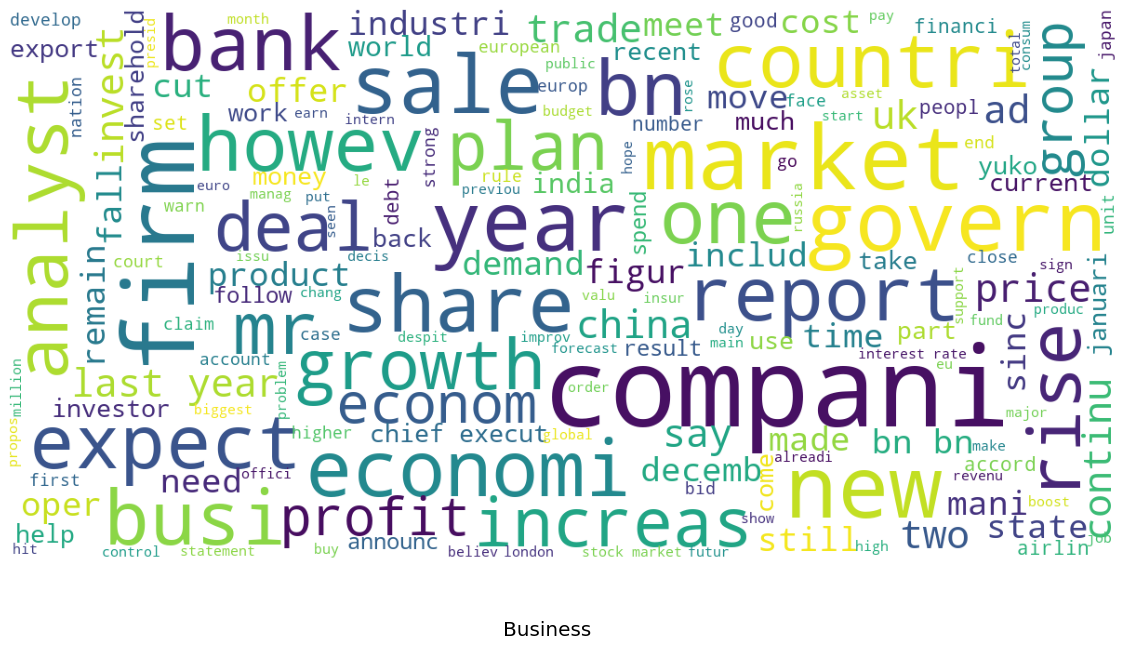

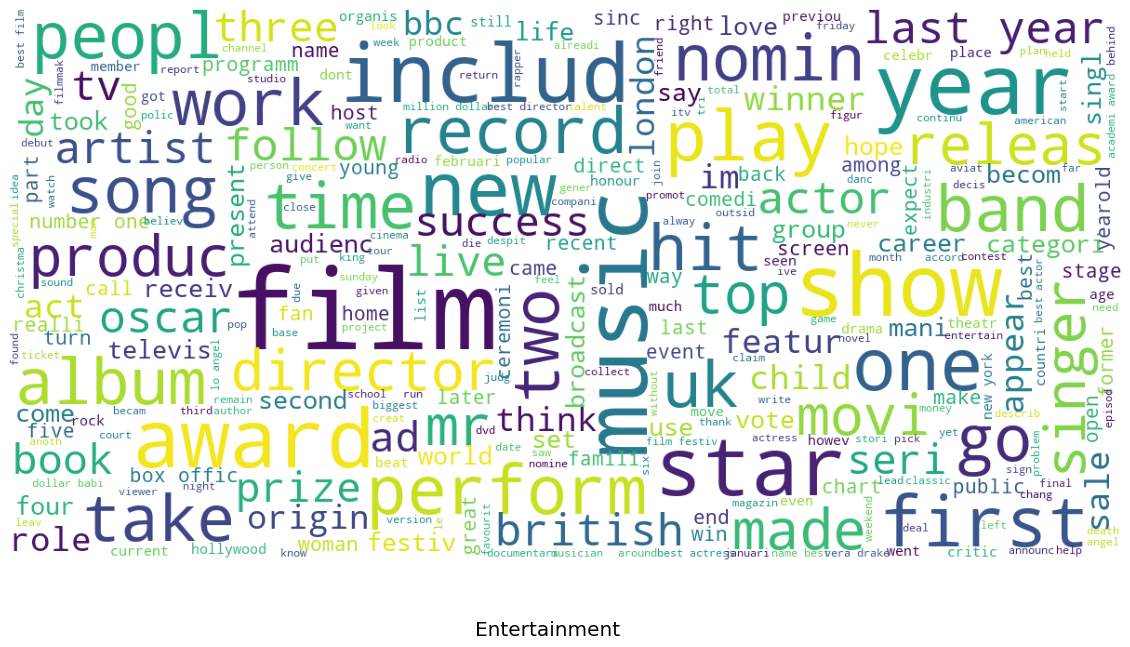

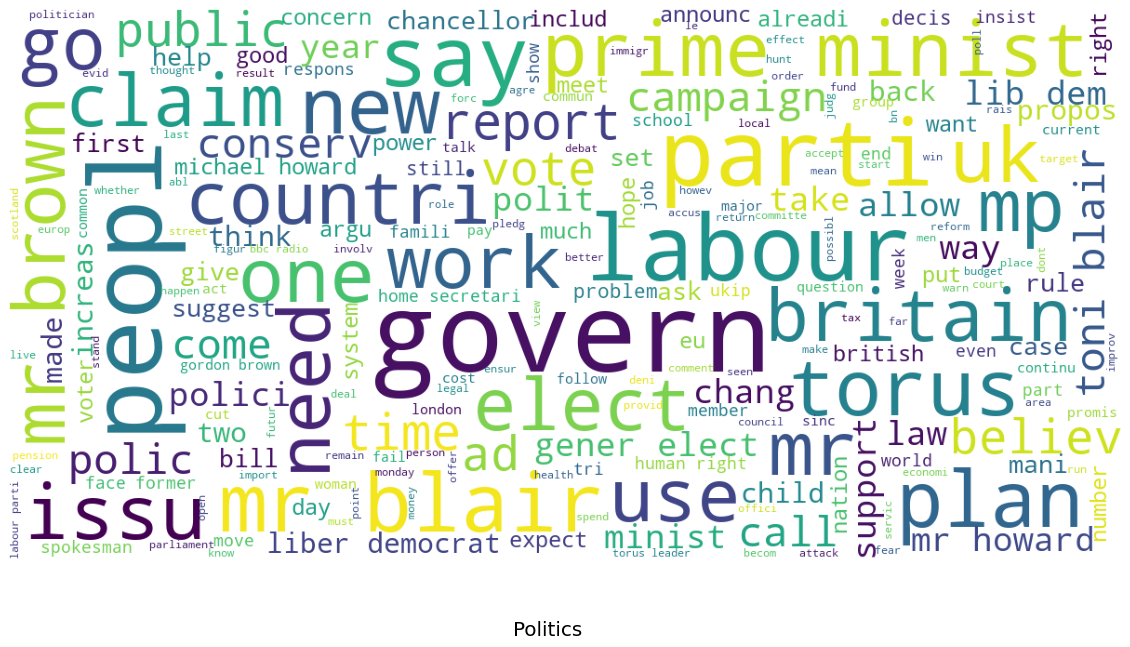

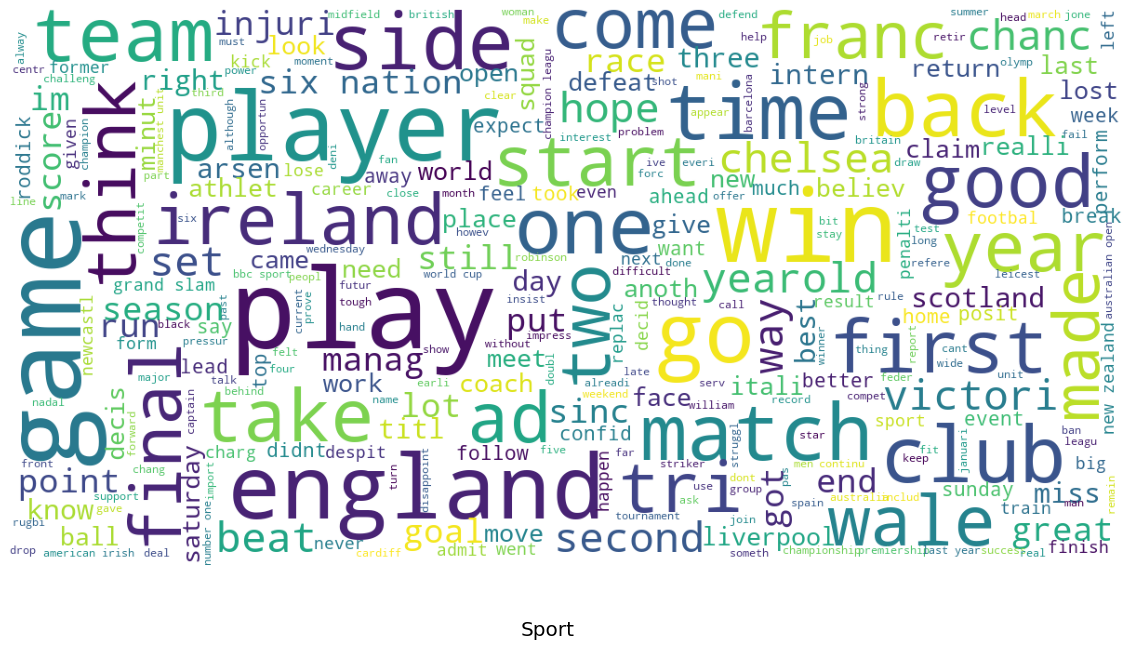

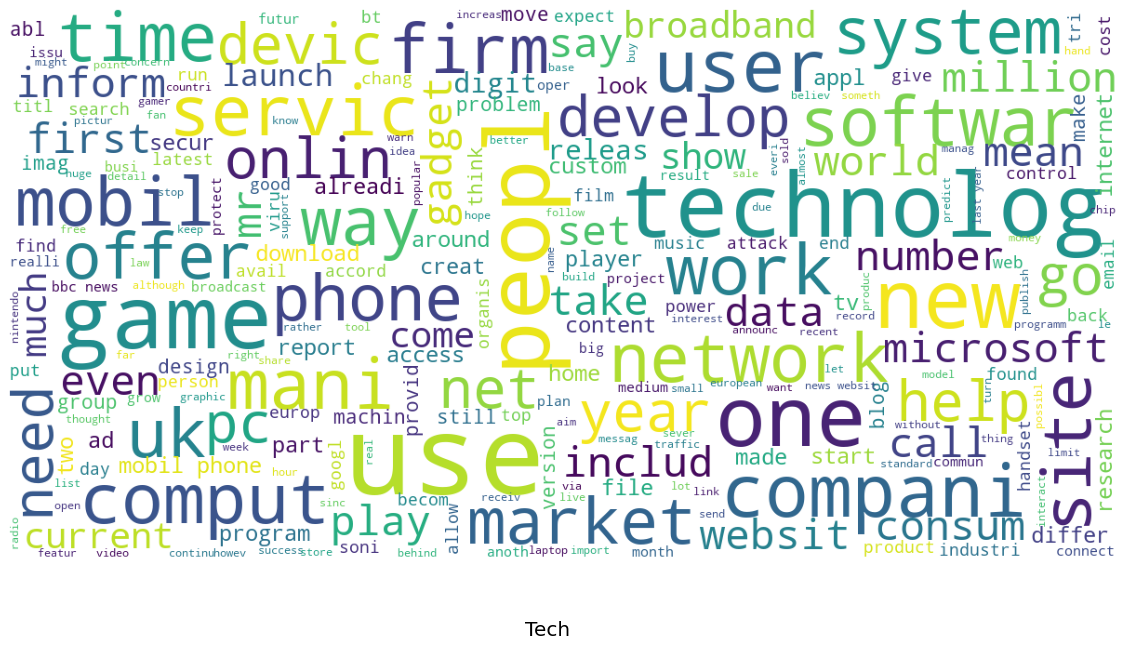

In [17]:
# my_word_cloud: CREATES A WORDCLOUD FROM A DATAFRAME'S COLUMN
def my_word_cloud(dataframe, column_name, title = None, max_words = 1000):
    wordcloud = WordCloud(
        background_color = "white",
        max_words = max_words,
        max_font_size = 40,
        scale = 3,
        random_state = 0
    ).generate(" ".join(dataframe[column_name]))
    fig = plt.figure(1, figsize=(20,20))
    plt.axis("off")
    if title != None:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
    
# CREATE DATAFRAMES BY CATEGORY
business = data_set.loc[data_set["category"] == "business"]
entertainment = data_set.loc[data_set["category"] == "entertainment"]
politics = data_set.loc[data_set["category"] == "politics"]
sport = data_set.loc[data_set["category"] == "sport"]
tech = data_set.loc[data_set["category"] == "tech"]
# CREATE WORDCLOUDS
my_word_cloud(business,"clean_content_stems_lemmas","Business")
my_word_cloud(entertainment,"clean_content_stems_lemmas","Entertainment")
my_word_cloud(politics,"clean_content_stems_lemmas","Politics")
my_word_cloud(sport,"clean_content_stems_lemmas","Sport")
my_word_cloud(tech,"clean_content_stems_lemmas","Tech")